In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="Paired")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

    
from logger import *
setup_logging(default_level=logging.INFO)

from sklearn import manifold, datasets
from sklearn.utils import check_random_state


from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from algo.fa import LinearQ3
from algo.apprenticeship_learning import ApprenticeshipLearning as AL
from env.simulator import * 
from util.plotting import *
from util.basis import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
action_list = range(env.action_space.n)
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)
# default


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [8]:
# hack to give us control over the initial state
import types

def new_timelimit_reset(self, s_init=None):
    import time
    self._episode_started_at = time.time()
    self._elapsed_steps = 0
    return self.env.reset(s_init)

def new_reset(self, s_init):
    if s_init is None:
        s_init = [np.random.uniform(-0.6, -0.4), 0]
    self.state = np.array(s_init)
    return np.array(self.state)
env.reset = types.MethodType(new_timelimit_reset, env)
env.env.reset = types.MethodType(new_reset, env.env)

## suppose we're given 3 types of training data D
- uniformly sampled across state space

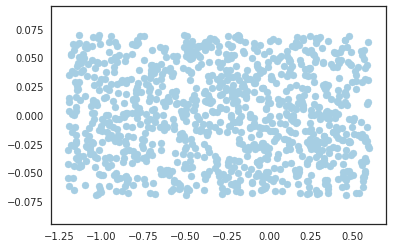

In [27]:
def generate_state_samples(env, pi, n_sample=1000):
    """
    a hacky way to cover most state space uniformly
    """
    D = []
    states=np.array([env.observation_space.sample() for _ in range(n_sample)])
    for s in states:
        env.reset(s)
        a = pi.choose_action(s)
        s_next, r, done, _ = env.step(a)
        # one transition = one episode
        D.append([[s, a, r, s_next, done]])
    return D


D_size = 1000
print("sample size of {}".format(D_size))
states=np.array([env.observation_space.sample() for _ in range(D_size)])
plt.scatter(states[:, 0], states[:, 1])
pi_random = RandomPolicy2(action_list)
D = generate_state_samples(env, pi_random, D_size)
D_mat = Simulator.to_matrix(D)

## obtain the expert policy $\pi_{exp}$
- with simulation (we don't assume we have access to this)
- however, we will asssume we know $\mu_{exp}(s_0)$ for a fixed $s_0 = (-0.5, 0)$
- in practice, $\mu_{exp}$ itself should be estimated from D, not from simulation
- with linearly paramatized Q
- with Guassian Kernel features

In [34]:
include_action = False
# if this is True, then the state space becomes very large
# therefore, a more denser, higher number of phi is needed
precision = 1e-2
eps = 0.01 # for LSPI
gamma = 0.99

n_component = 5
add_bias = True
standardized = True
p_gaus = (n_component**2 + int(add_bias)) * n_action

# IMPORANT
states_in_D = np.vstack(D_mat[:, 0])
phi_gaus = GaussianKernel(states_in_D, n_action, p_gaus, n_component, include_action, add_bias, standardized).transform

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 113 @ Episode 150/150 (-117.0)

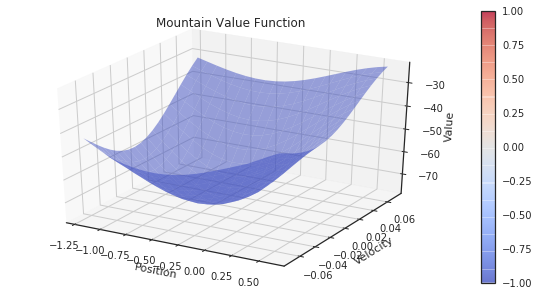

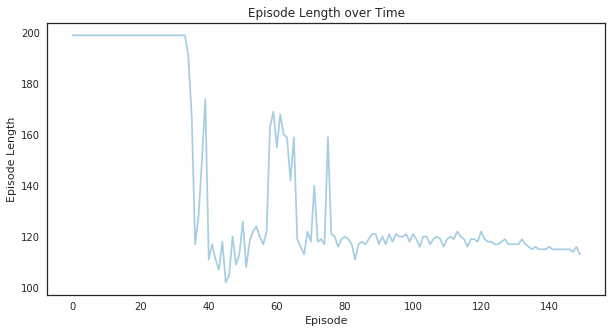

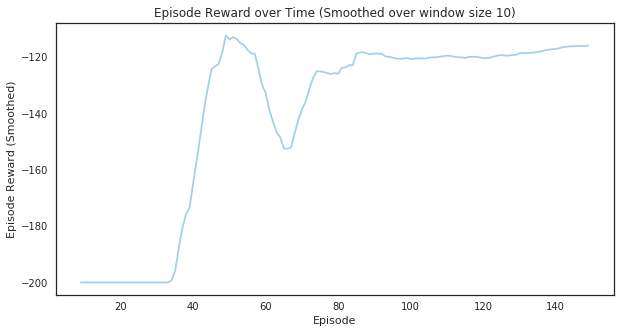

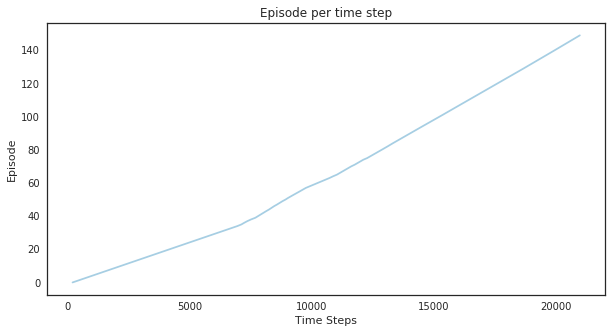

(<matplotlib.figure.Figure at 0x7ff4006e6f98>,
 <matplotlib.figure.Figure at 0x7ff3fecd3898>)

In [35]:
phi = phi_gaus
p = p_gaus

mdp_solver = LinearQ3(env=env,
                      phi=phi,
                      p=p,
                      action_list=action_list,
                      n_episode=150,
                      epsilon=0.0,
                      epsilon_decay=1.00,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve(reward_fn=None)
plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)

## Apprenticeship Learning
- [ ] fitted reward
- [ ] margin plot
- [ ] show trajectories
- [ ] implement MMP
- dillemma ...

## Solve MountainCar-v0 with LSPI


In [24]:
def solve_mountain_car(p, phi, gamma, precision, eps, D, reward_fn=None, max_iter=10):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=reward_fn,
                max_iter=max_iter)

    W, w_list = lspi.solve()
    return W, w_list

# mixed

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
#w_gaus, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_mat, reward_fn3, 3)

# pure

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
#w_gaus, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_pure_mat, None, 3)


# fake

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
w_gaus, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_fake_mat, None, 3)

INFO:root:fitting D of the dimension:
(10000, 5)
INFO:root:lspi norm 72635.92269631934
INFO:root:lspi norm 3915.228624980752
INFO:root:lspi norm 2459.904823663697
INFO:root:lspi norm 946.6959553872856
INFO:root:lspi norm 40.303494427131085


## check the policies returned by LSPI

Step 198 @ Episode 30/30 (-200.0)

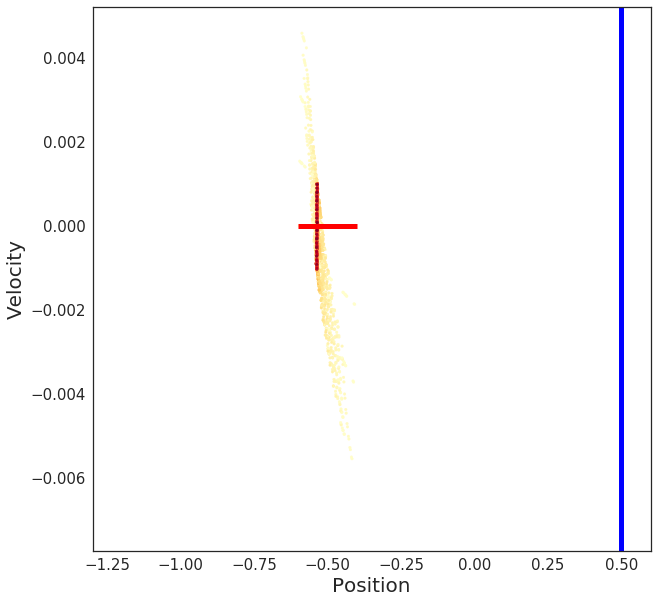

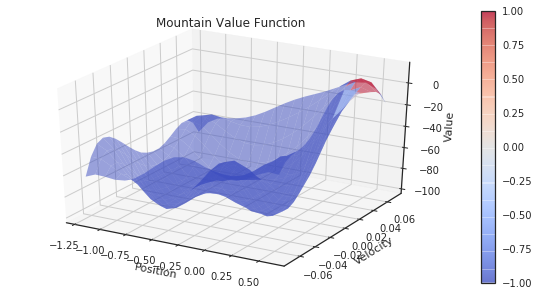

Step 85 @ Episode 30/30 (-154.0))

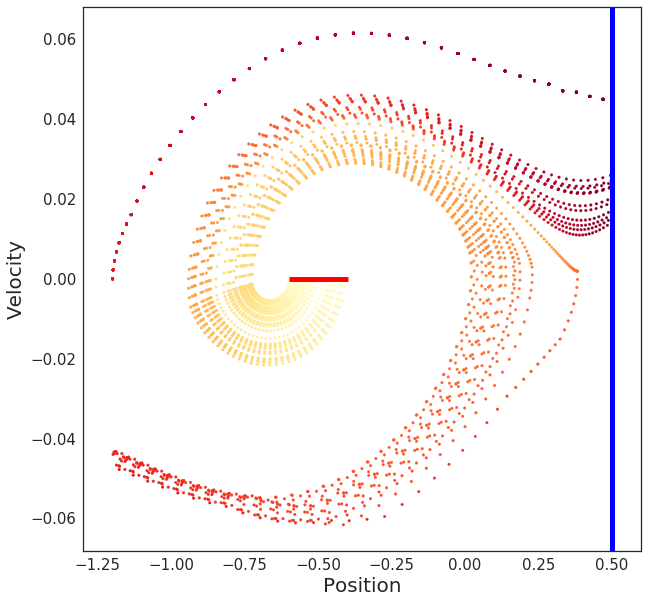

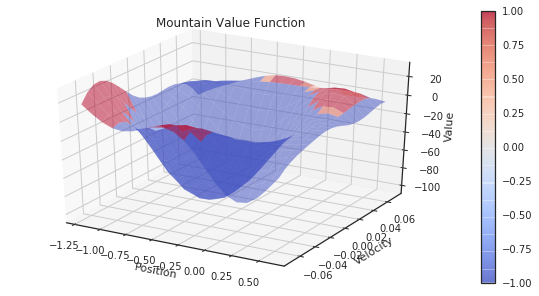

Step 149 @ Episode 30/30 (-88.0))

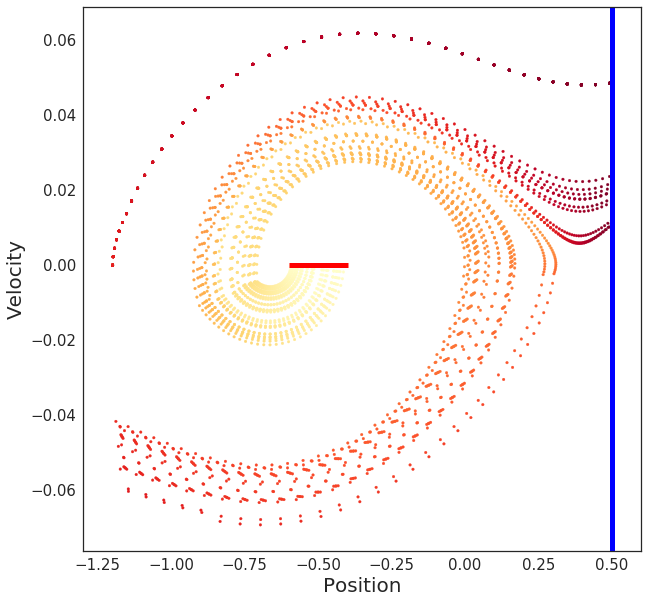

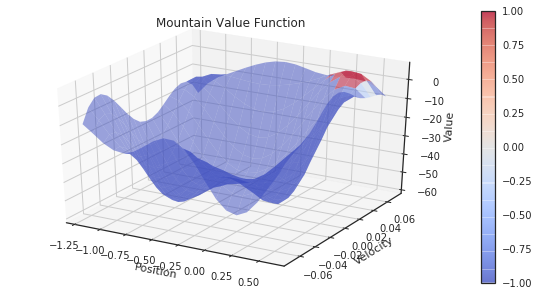

Step 83 @ Episode 30/30 (-95.0)))

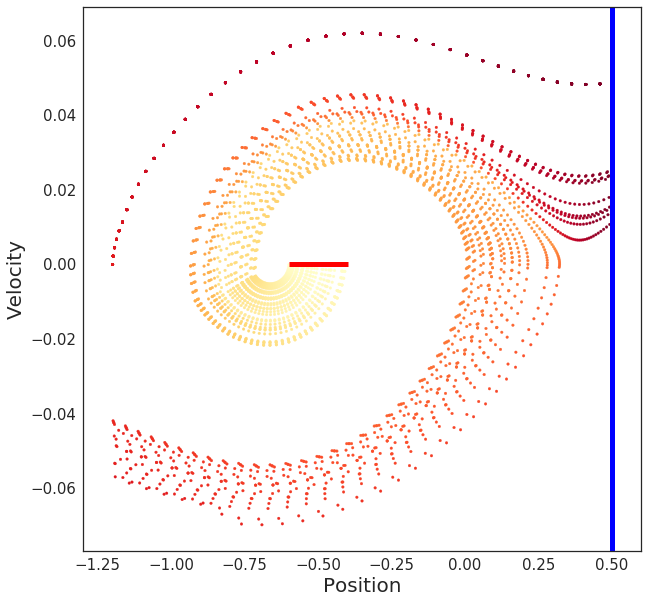

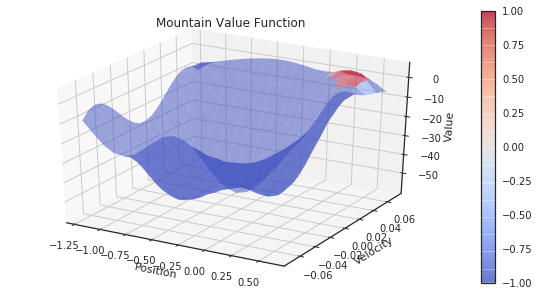

Step 86 @ Episode 30/30 (-148.0))

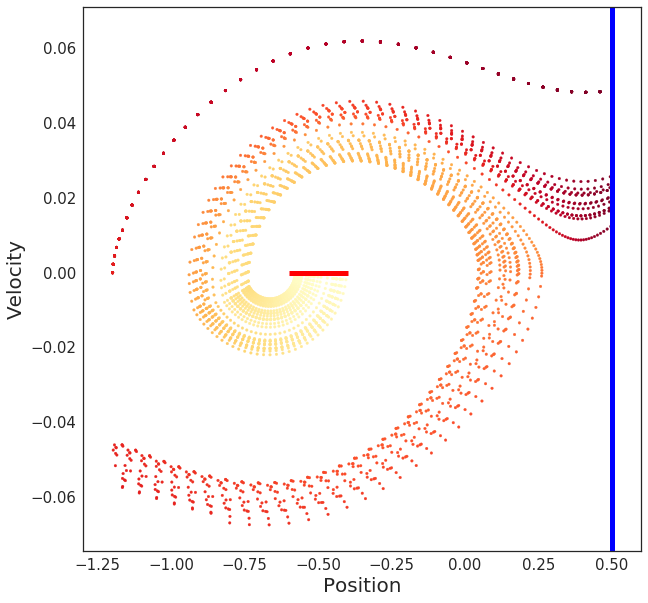

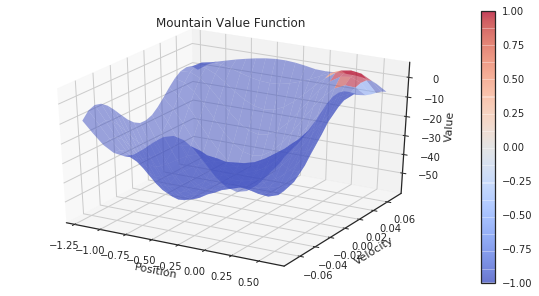

In [25]:
phi = phi_gaus

for w in w_list: 
    pi_star = LinearQ2(action_list=action_list, phi=phi, W=w)
    #pi_star = LinearQ2(action_list=action_list, phi=phi_linear, W=W_linear)
    D_star, stats = sim.simulate(pi=pi_star, n_trial=1, n_episode=30, return_stats=True)
    plot_trajectory_mountain_car(D_star)    
    plot_cost_to_go_mountain_car(env, pi_star)
    #plot_episode_stats(stats, smoothing_window=5)